In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, plot_confusion_matrix, precision_recall_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [29]:
def convert_to_categorical(col): 
    if col == 0: 
        return 1 # paid (positive class)
    else: 
        return 0 #  did not pay (negative class)

In [43]:
def plot_errors(model, X_test): 
    X_test_temp = X_test.copy()
  

    plt.subplots(figsize=(12, 8))
    
    X_test_temp = X_test.assign(
        preds = model.predict(X_test), 
        brand = y_test
    )
    
    X_test_temp['target'] = y_test #pd.concat([X_test_temp1,y_test ], axis = 1)
   
    sns.scatterplot(data=X_test_temp, x='f77', y='f3', hue='target', alpha=.3)

    errors = X_test_temp.query('preds != target')
    sns.scatterplot(data=errors, x='f1', y='f3', color='red')

    plt.title('Error (red) analysis')
    plt.show()

In [4]:
def model_check(y_true, y_pred, model): 
    #print('Accuracy :', precision_score(y_true, y_pred), '\nRecall :', recall_score(y_true, y_pred))
    prec = round( precision_score(y_true, y_pred) *100, 2)
    recall = round( recall_score(y_true, y_pred)*100 , 2)
    conf_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred))
    conf_matrix.set_index(model.classes_, inplace=True)
    conf_matrix.columns = model.classes_
    return conf_matrix , prec ,  recall 

# Read the data

In [5]:
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [6]:
data = pd.read_csv('/content/drive/MyDrive/data/loan-default-iter2.csv', index_col='id')


In [7]:
data.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,...,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,loss
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,126,10,0.686842,1100,3,13699,7201.0,4949.0,126.75,126.03,7,0.7607,0.7542,612922,0.7236,0.7236,0.5171,0.7236,0.8476,0.7876,1.097851e+09,89,66,998046.0,89.0,89.0,89.00,89.00,89.0,0.9271,0,0,0,5,0,0,0.73180,0.72124,0.749280,5.0,...,5.0,0.95355,0.93439,0.960160,0.025156,4.5785,6,-0.01,0.00,0.1127,-0.03,9,5,5.11,2.19,6.04,43501.0,389999.0,0.99,1.40,0.51,0.90,0.12,862.0,862.0,862.0,862.0,0.32,1.35,1.62,0.15,0.01,0.12,851.0,851.0,851.0,851.0,0.32,1.34,0
2,121,10,0.782776,1100,3,84645,240.0,1625.0,123.52,121.35,7,0.6555,0.6555,245815,0.6341,0.6341,0.3909,0.6667,0.6903,0.6903,8.449459e+08,78,50,754416.0,78.0,78.0,78.00,78.00,78.0,0.8478,0,0,0,6,0,0,0.65705,0.64069,0.626200,6.0,...,6.0,0.85390,0.85302,0.793950,0.142922,4.5785,6,-0.04,-0.03,0.0143,-0.14,9,6,4.19,3.86,6.10,1464.0,12362.0,0.92,1.36,0.02,0.00,0.11,26.0,26.0,26.0,26.0,0.31,1.36,1.65,0.29,0.09,0.08,20.0,20.0,20.0,20.0,0.28,1.43,0
3,126,10,0.500080,1100,3,83607,1800.0,1527.0,127.76,126.49,7,0.7542,0.7542,1385872,0.7542,0.7542,0.5508,0.7542,0.8091,0.7807,1.308478e+09,89,54,1037651.0,89.0,89.0,100.43,94.37,89.0,0.9175,0,0,0,13,0,0,0.74710,0.75878,0.654685,13.0,...,13.0,0.88875,0.91575,0.798423,0.254750,4.5785,6,-0.03,-0.04,0.0218,-0.01,9,13,4.72,4.81,7.20,12951.0,128339.0,0.92,1.39,0.01,0.00,0.07,134.0,134.0,134.0,134.0,0.26,1.50,1.87,0.01,0.00,0.07,124.0,124.0,124.0,124.0,0.25,1.52,0
4,134,10,0.439874,1100,3,82642,7542.0,1730.0,132.94,133.58,7,0.8017,0.7881,704687,0.7881,0.7881,0.5923,0.7881,0.8230,0.8158,1.472752e+09,93,55,1115721.0,93.0,93.0,114.63,102.92,93.0,0.9688,0,0,0,4,0,0,0.77405,0.78929,0.750675,4.0,...,4.0,0.95440,0.97192,0.928550,0.067230,4.5785,6,0.02,0.03,0.0114,0.01,9,4,6.35,6.82,5.97,45062.0,410200.0,1.00,1.42,0.01,0.00,0.14,1088.0,1088.0,1088.0,1088.0,0.35,1.28,1.52,0.01,0.00,0.12,903.0,903.0,903.0,903.0,0.32,1.35,0
5,109,9,0.502749,2900,4,79124,89.0,491.0,122.72,112.77,6,0.5263,0.5263,51985,0.5263,0.5263,0.3044,0.5405,0.5556,0.5455,1.442916e+09,60,21,536400.0,60.0,60.0,60.00,60.00,60.0,0.8451,0,0,0,26,0,0,0.60315,0.53367,0.696150,26.0,...,26.0,0.86255,0.85059,0.870969,0.075199,4.9649,6,-0.20,-0.26,0.0038,-0.14,8,26,2.78,1.95,6.34,564.0,4416.0,0.62,1.25,0.26,0.09,0.06,5.0,5.0,5.0,5.0,0.23,1.56,1.99,0.51,0.90,0.06,5.0,5.0,5.0,5.0,0.23,1.56,0


In [8]:
check_nan = pd.DataFrame( data.isnull().sum() , columns= ['val'])

In [9]:
nan_col = check_nan.query('val > 500').index.to_list()

In [10]:
len(nan_col)

23

In [11]:
data.drop(columns= nan_col, inplace= True)

In [12]:
data.isna().sum().sum() 

6149

In [13]:
data.dropna(inplace=True)

In [14]:
data.shape

(78812, 76)

In [15]:
data.drop( columns = ['f33' ,'f34' ,'f35' ,'f37', 'f38'], inplace = True)

In [16]:
data.shape

(78812, 71)

In [17]:
data['target'] = data['loss'].apply(convert_to_categorical)

In [18]:
not_paid = data.query('target == 0 ')

In [19]:
data.query('target == 1 ')

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f13,f14,f15,f16,f17,f18,f19,f20,f24,f25,f27,f28,f29,f30,f36,f39,f40,f41,f42,f43,f49,f50,f51,f52,f53,f55,f56,f57,f58,f65,f67,f68,f69,f70,f71,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f92,f93,f94,f95,f96,f97,f98,f99,loss,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,126,10,0.686842,1100,3,13699,7201.0,4949.0,126.75,126.03,7,0.7607,0.7542,612922,0.7236,0.7236,0.5171,0.7236,89,66,89.0,89.0,89.00,89.00,5,0.73180,0.72124,0.749280,5.0,0.026826,0.75710,0.75878,0.767820,5.0,0.013870,0.53855,0.52539,0.551920,5.0,0.960160,4.5785,6,-0.01,0.00,0.1127,9,5,5.11,2.19,6.04,43501.0,389999.0,0.99,1.40,0.51,0.90,0.12,862.0,862.0,862.0,862.0,0.32,0.15,0.01,0.12,851.0,851.0,851.0,851.0,0.32,0,1
2,121,10,0.782776,1100,3,84645,240.0,1625.0,123.52,121.35,7,0.6555,0.6555,245815,0.6341,0.6341,0.3909,0.6667,78,50,78.0,78.0,78.00,78.00,6,0.65705,0.64069,0.626200,6.0,0.107658,0.67775,0.66995,0.642050,6.0,0.112048,0.42545,0.41181,0.393817,6.0,0.793950,4.5785,6,-0.04,-0.03,0.0143,9,6,4.19,3.86,6.10,1464.0,12362.0,0.92,1.36,0.02,0.00,0.11,26.0,26.0,26.0,26.0,0.31,0.29,0.09,0.08,20.0,20.0,20.0,20.0,0.28,0,1
3,126,10,0.500080,1100,3,83607,1800.0,1527.0,127.76,126.49,7,0.7542,0.7542,1385872,0.7542,0.7542,0.5508,0.7542,89,54,89.0,89.0,100.43,94.37,13,0.74710,0.75878,0.654685,13.0,0.208224,0.74710,0.75878,0.656654,13.0,0.208174,0.54540,0.55572,0.502138,13.0,0.798423,4.5785,6,-0.03,-0.04,0.0218,9,13,4.72,4.81,7.20,12951.0,128339.0,0.92,1.39,0.01,0.00,0.07,134.0,134.0,134.0,134.0,0.26,0.01,0.00,0.07,124.0,124.0,124.0,124.0,0.25,0,1
4,134,10,0.439874,1100,3,82642,7542.0,1730.0,132.94,133.58,7,0.8017,0.7881,704687,0.7881,0.7881,0.5923,0.7881,93,55,93.0,93.0,114.63,102.92,4,0.77405,0.78929,0.750675,4.0,0.043725,0.77405,0.78929,0.761825,4.0,0.045525,0.58615,0.59307,0.573525,4.0,0.928550,4.5785,6,0.02,0.03,0.0114,9,4,6.35,6.82,5.97,45062.0,410200.0,1.00,1.42,0.01,0.00,0.14,1088.0,1088.0,1088.0,1088.0,0.35,0.01,0.00,0.12,903.0,903.0,903.0,903.0,0.32,0,1
5,109,9,0.502749,2900,4,79124,89.0,491.0,122.72,112.77,6,0.5263,0.5263,51985,0.5263,0.5263,0.3044,0.5405,60,21,60.0,60.0,60.00,60.00,26,0.60315,0.53367,0.696150,26.0,0.062251,0.61315,0.53367,0.715869,26.0,0.070823,0.37220,0.31396,0.483685,26.0,0.870969,4.9649,6,-0.20,-0.26,0.0038,8,26,2.78,1.95,6.34,564.0,4416.0,0.62,1.25,0.26,0.09,0.06,5.0,5.0,5.0,5.0,0.23,0.51,0.90,0.06,5.0,5.0,5.0,5.0,0.23,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,125,8,0.353172,1300,4,12421,4193.0,5895.0,124.94,124.86,16,0.8448,0.8305,7441897,0.8305,0.8305,0.6271,0.8376,98,76,98.0,98.0,98.00,98.00,14,0.81525,0.82745,0.804029,14.0,0.076032,0.81525,0.82745,0.814043,14.0,0.076007,0.62355,0.62439,0.626379,14.0,0.941479,13.4202,16,0.00,0.01,0.0582,8,14,4.93,3.27,6.80,28522.0,270844.0,0.97,1.42,0.02,0.00,0.08,328.0,328.0,328.0,328.0,0.27,0.04,0.00,0.08,343.0,343.0,343.0,343.0,0.27,0,1
79996,117,8,0.071314,1300,4,76831,4614.0,3102.0,120.50,117.52,16,0.6949,0.6949,2815503,0.6949,0.6949,0.4355,0.7009,82,32,82.0,82.0,101.07,90.75,4,0.73745,0.70541,0.754225,4.0,0.073105,0.73745,0.70541,0.755575,4.0,0.071633,0.50775,0.45195,0.544400,4.0,0.921400,13.4202,16,-0.06,-0.04,0.0420,9,4,7.18,9.24,6.73,31036.0,291728.0,0.93,1.38,0.01,0.00,0.09,404.0,404.0,404.0,404.0,0.28,0.26,0.09,0.09,422.0,422.0,422.0,422.0,0.29,0,1
79997,125,8,0.793560,1300,4,83549,1205.0,2950.0,124.11,124.77,16,0.6935,0.6935,2089695,0.6992,0.6935,0.4804,0.7414,86,39,86.0,86.0,106.00,95.18,11,0.75675,0.70415,0.782882,11.0,0.049686,0.75675,0.70415,0.784045,11.0,0.049359,0.55020,0.49236,0.572691,11.0,0.947736,13.4202,16,0.01,0.02,0.0025,9,11,7.76,8.38,6.60,7951.0,72995.0,0.90,1.35,0.16,0.01,0.09,111.0,111.0,111.0,111.0,0.29,0.03,0.00,0.10,117.0,117.0,117.

# Pre-process the data

In [20]:

# check for duplicated values 
data.duplicated().unique()

# check and deal with missing values 
data[data.isnull().any(axis=1)]
data.dropna(inplace=True)

# drop columns that are zeros
#data.drop( columns = ['f33' ,'f34' ,'f35' ,'f37', 'f38'], inplace = True)

# convert the target into categorical
data['target'] = data['loss'].apply(convert_to_categorical)
data.target.value_counts()

# balance the data
not_paid = data.query('target == 0 ')
# maybe shuffling is a good option
#paid = data.query('target == 0 ').sample(frac=1).reset_index(drop=True).iloc[0:6446 , :]
paid = data.query('target == 1 ').sample(frac=1).reset_index(drop=True).iloc[0:7221 , :]
#paid = data.query('target == 0 ').iloc[0:6446 , :]
data3 = pd.concat([not_paid, paid])
df = data3.sample(frac=1).reset_index(drop=True)

#X = df[ ['f1','f3','f5','f6','f7','f9','f10','f43','f53','f78','f79'  ] ]
X =  df.iloc[:, 0:-2]
y = df['target'] # independent variable

X_train, X_test, y_train, y_test = train_test_split(X , y, random_state=42)


In [22]:
10831 / 14442

0.7499653787564049

## Normalize the data

In [23]:
my_min_max = MinMaxScaler(feature_range=(0,1))

X_train_sc = pd.DataFrame(my_min_max.fit_transform(X_train),
                 index=X_train.index,
                 columns=X_train.columns)
X_test_sc = pd.DataFrame(my_min_max.transform(X_test),
                 index=X_test.index,
                 columns=X_test.columns)

# Correlation Coefficient 

In [24]:
corr_coef = pd.DataFrame( df.corr()['target'].sort_values() )

In [25]:
corr_col = pd.concat( [corr_coef.head(3), corr_coef.tail(5)] ).drop(index = ["target", "loss"] ).index.to_list()

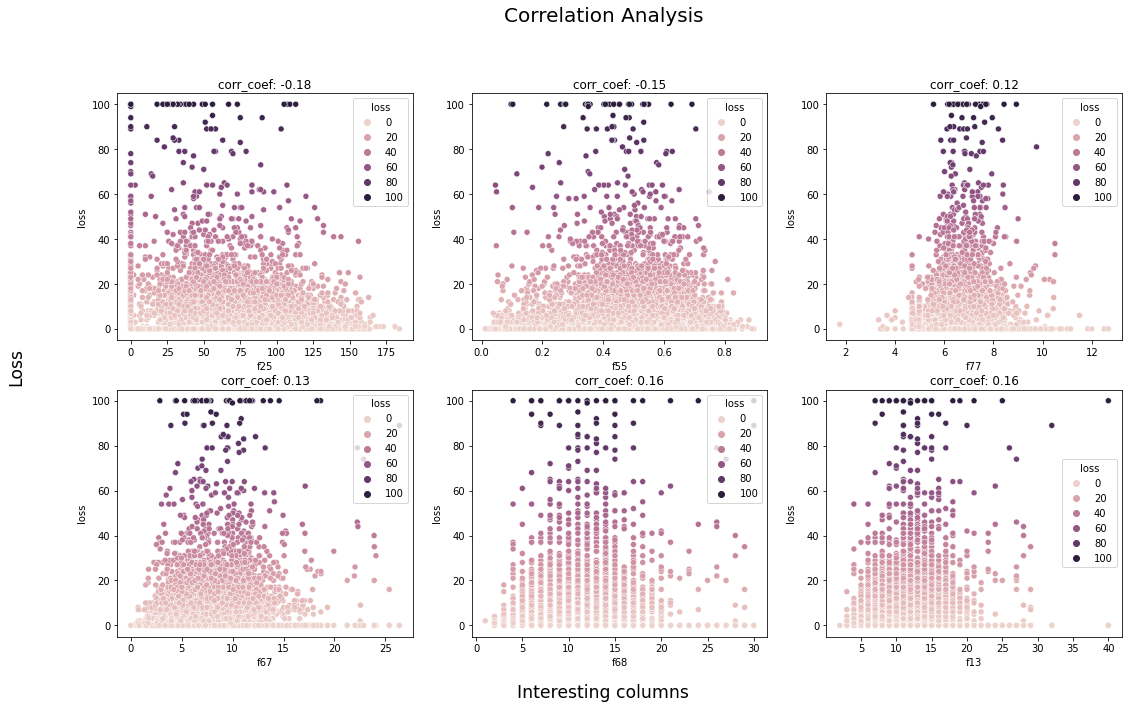

In [26]:

fig, axes = plt.subplots(2, 3, figsize=(18, 10), squeeze=False)
fig.text(0.5, 0.04, 'Interesting columns', ha='center', fontsize = 'xx-large')
fig.text(0.04, 0.5, 'Loss', va='center', rotation='vertical', fontsize= 'xx-large')
axli = axes.flatten()
i = 0 

fig.suptitle('Correlation Analysis', x= 0.5 , y = 1,   fontsize = 20)

for col in corr_col:
  
 
  axli[i].set_title( "corr_coef: " + str(  round(corr_coef.loc[col,'target'],2)  ))
  # try to add some color to target group, to see the difference on each distribution
  sns.scatterplot( ax =axli[i] , data=df, x=col, y='loss', hue = 'loss') # , hue='target'
  
  
  i = i + 1




# Cross Validation 

In [ ]:
classification_models = []
classification_models.append(('Logistic Regression', LogisticRegression(solver="liblinear")))
classification_models.append(('K Nearest Neighbor', KNeighborsClassifier(n_neighbors=5, metric="minkowski",p=2)))
classification_models.append(('Kernel SVM', SVC(kernel = 'rbf',gamma='scale')))
classification_models.append(('Decision Tree', DecisionTreeClassifier(criterion = "entropy")))
classification_models.append(('Random Forest', RandomForestClassifier(n_estimators=100, criterion="entropy")))
classification_models.append(('Naive Bayes', GaussianNB()))
result = []
for name, model in classification_models:
  kfold = KFold(n_splits=5, random_state=7)
  res = cross_val_score(model, X_train_sc, y_train, cv=kfold, scoring='accuracy')
  print("%s: Mean Accuracy = %.2f%% - SD Accuracy = %.2f%%" % (name, res.mean()*100, res.std()*100))
  result.append([name,round(res.mean()*100,2)])# "%s: Mean Accuracy = %.2f%% - SD Accuracy = %.2f%%" % (name, res.mean()*100, res.std()*100))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Logistic Regression: Mean Accuracy = 63.91% - SD Accuracy = 0.40%


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


K Nearest Neighbor: Mean Accuracy = 56.91% - SD Accuracy = 1.09%


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Kernel SVM: Mean Accuracy = 63.27% - SD Accuracy = 0.76%


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Decision Tree: Mean Accuracy = 53.75% - SD Accuracy = 0.57%


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Random Forest: Mean Accuracy = 61.57% - SD Accuracy = 0.61%
Naive Bayes: Mean Accuracy = 59.57% - SD Accuracy = 0.36%


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
result

[['Logistic Regression', 63.91],
 ['K Nearest Neighbor', 56.91],
 ['Kernel SVM', 63.27],
 ['Decision Tree', 53.75],
 ['Random Forest', 61.57],
 ['Naive Bayes', 59.57]]

# Model Comparison

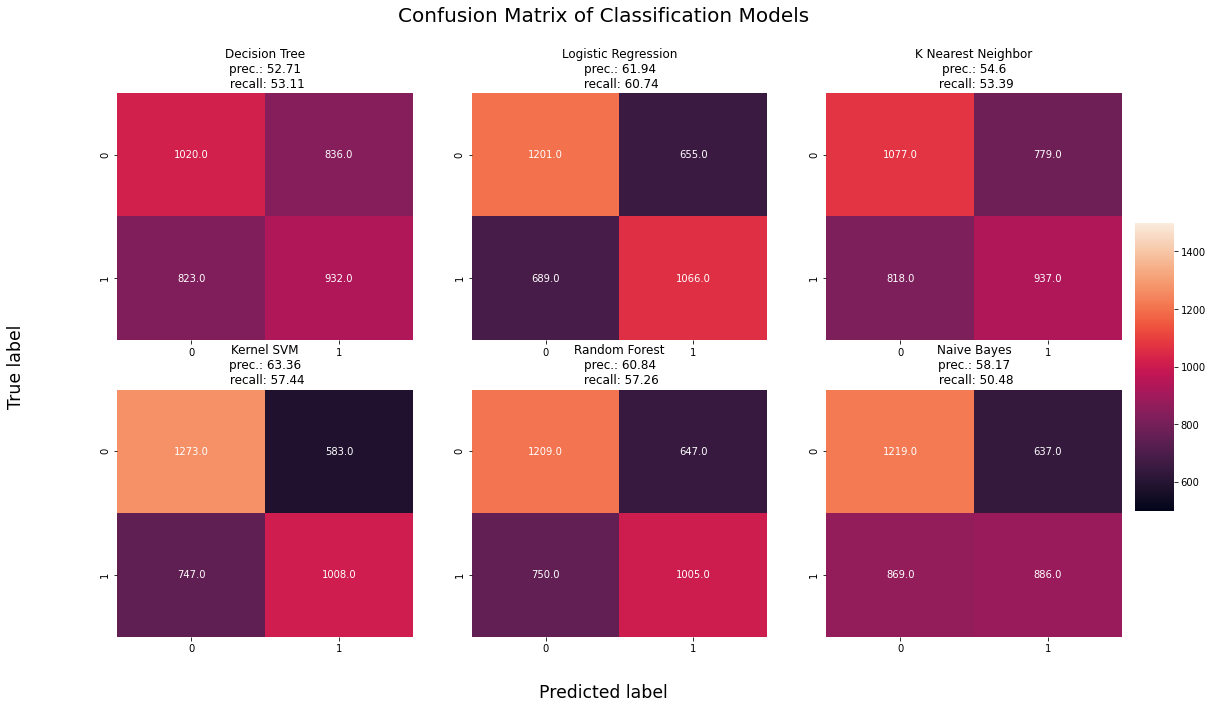

In [27]:
classification_models = []
classification_models.append(('Decision Tree', DecisionTreeClassifier(criterion = "entropy")))
classification_models.append(('Logistic Regression', LogisticRegression(solver="liblinear")))
classification_models.append(('K Nearest Neighbor', KNeighborsClassifier(n_neighbors=5, metric="minkowski",p=2)))
classification_models.append(('Kernel SVM', SVC(kernel = 'rbf',gamma='scale')))
classification_models.append(('Random Forest', RandomForestClassifier(n_estimators=100, criterion="entropy")))
classification_models.append(('Naive Bayes', GaussianNB()))


fig, axes = plt.subplots(2, 3, figsize=(18, 10), squeeze=False)
fig.text(0.5, 0.04, 'Predicted label', ha='center', fontsize = 'xx-large')
fig.text(0.04, 0.5, 'True label', va='center', rotation='vertical', fontsize= 'xx-large')
axli = axes.flatten()
i = 0 
cbar_ax = fig.add_axes([.91,.3,.03,.4])
fig.suptitle('Confusion Matrix of Classification Models', x= 0.5 , y = 1,   fontsize = 20)

for name, model in classification_models:
  
  model_type = model
  model_type.fit(X_train_sc, y_train)
  conf_matrix , prec ,  call = model_check(y_test, model_type.predict(X_test_sc), model_type)

  axli[i].set_title(name + '\n' + 'prec.: ' +str(prec) + '\n recall: ' + str(call) )
  #axes[0, 0].set_title(name + '\n' + 'acc: ' +str(acc) + '\n call: ' + str(call) )
  sns.heatmap(ax=axli[i], data=conf_matrix, annot=True, fmt = '.1f', cbar_ax = cbar_ax, cbar=True, vmin=500,vmax=1500)
  
  i = i + 1


# Feature Importance

Text(0, 0.5, 'Variable name')

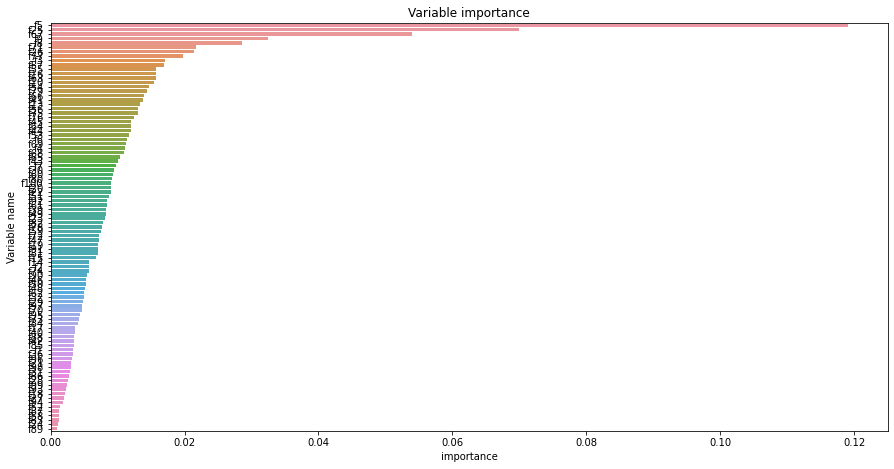

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train_transformed, y_train)

plt.figure(figsize=(15, 7.5))
var_importance = pd.DataFrame({
    'importance': tree.feature_importances_,
    'columns':X_train.columns
}).query('importance != 0').sort_values('importance', ascending=False)


sns.barplot(data=var_importance, x='importance', y='columns')
plt.title('Variable importance')
plt.ylabel('Variable name')

# Roc Curves

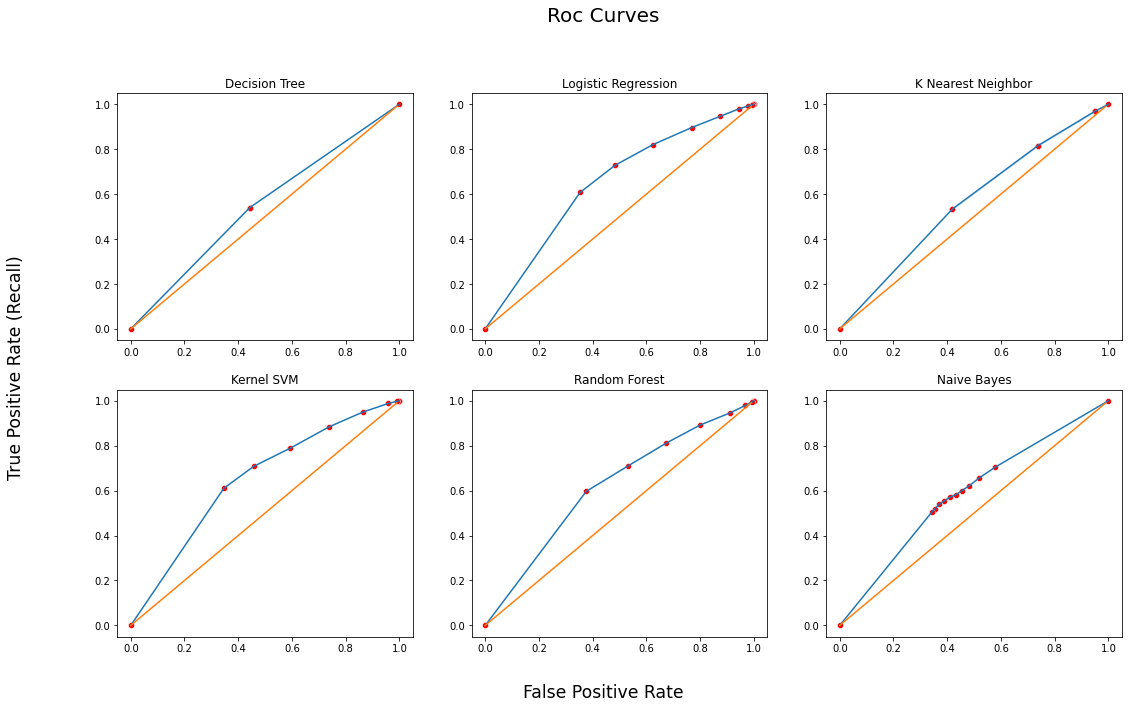

In [30]:
from sklearn.metrics import confusion_matrix
classification_models = []
classification_models.append(('Decision Tree', DecisionTreeClassifier(criterion = "entropy")))
classification_models.append(('Logistic Regression', LogisticRegression(solver="liblinear")))
classification_models.append(('K Nearest Neighbor', KNeighborsClassifier(n_neighbors=5, metric="minkowski",p=2)))
classification_models.append(('Kernel SVM', SVC(kernel = 'rbf',gamma='scale', probability= True)))
classification_models.append(('Random Forest', RandomForestClassifier(n_estimators=100, criterion="entropy")))
classification_models.append(('Naive Bayes', GaussianNB()))


fig, axes = plt.subplots(2, 3, figsize=(18, 10), squeeze=False)
fig.text(0.5, 0.04, 'False Positive Rate', ha='center', fontsize = 'xx-large')
fig.text(0.04, 0.5, 'True Positive Rate (Recall)', va='center', rotation='vertical', fontsize= 'xx-large')
axli = axes.flatten()
i = 0 

fig.suptitle('Roc Curves', x= 0.5 , y = 1,   fontsize = 20)

for name, model in classification_models:
  
  model_type = model
  model_type.fit(X_train_sc, y_train)
  probs = pd.DataFrame(model_type.predict_proba(X_test_sc))

  thresholds = [ 0.05, 0.1, 0.15 , 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
  sensitivities = [1]
  especifities_1 = [1]

  for t in thresholds: 
    probs['prediction'] = np.where(probs.iloc[:,1] >= t, 1, 0)
    probs['actual'] = list(y_test)
        
    y_actu = probs.actual.to_list()
    y_pred = probs.prediction.to_list()

        
    TN, FP, FN, TP = confusion_matrix(y_actu, y_pred).ravel()


    sens = TP/(TP+FN)
    sensitivities.append(sens)
    espc_1 = 1-TN/(TN+FP)
    especifities_1.append(espc_1)
        
  sensitivities.append(0)
  especifities_1.append(0)
  axli[i].set_title(name)
  sns.lineplot(ax=axli[i], x=especifities_1, y=sensitivities)
  sns.scatterplot(ax=axli[i], x=especifities_1, y=sensitivities, color='red')
  x=[j*0.01 for j in range(100)]
  y=[j*0.01 for j in range(100)]
  axli[i].plot(x,y)
  del probs
  sensitivities = []
  especifities_1 = []
    
  i = i + 1


# Precision and recall vs the decision threshold

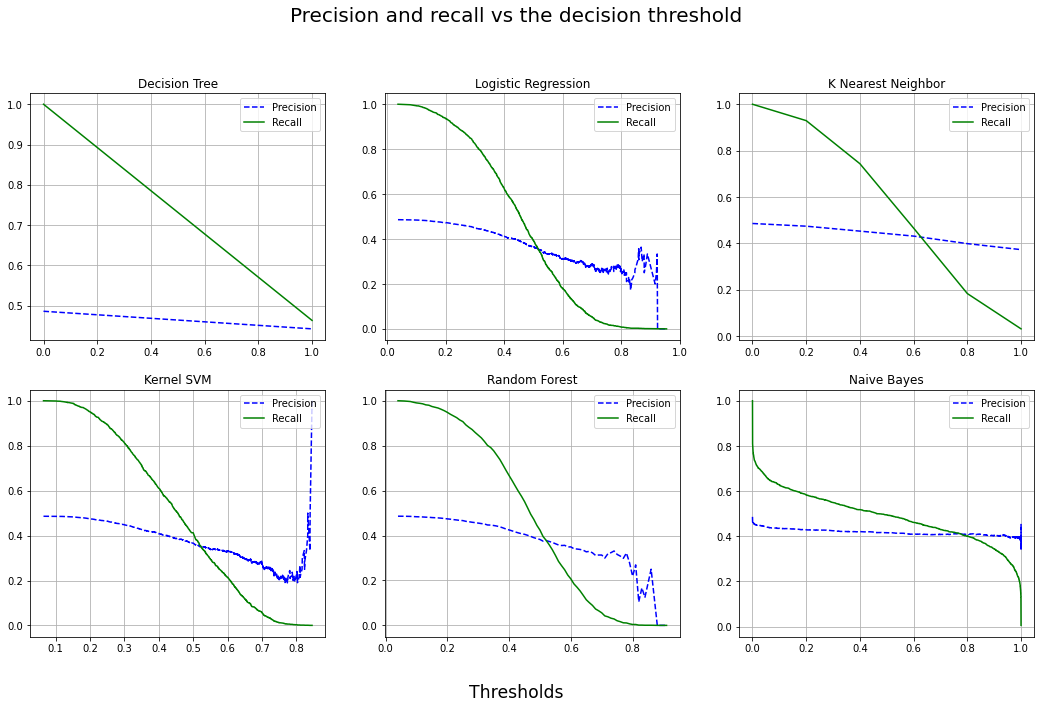

In [31]:
classification_models = []
classification_models.append(('Decision Tree', DecisionTreeClassifier(criterion = "entropy")))
classification_models.append(('Logistic Regression', LogisticRegression(solver="liblinear")))
classification_models.append(('K Nearest Neighbor', KNeighborsClassifier(n_neighbors=5, metric="minkowski",p=2)))
classification_models.append(('Kernel SVM', SVC(kernel = 'rbf',gamma='scale',  probability=True)))
classification_models.append(('Random Forest', RandomForestClassifier(n_estimators=100, criterion="entropy")))
classification_models.append(('Naive Bayes', GaussianNB()))


fig, axes = plt.subplots(2, 3, figsize=(18, 10), squeeze=False)

axli = axes.flatten()
i = 0 
fig.suptitle('Precision and recall vs the decision threshold', x= 0.5 , y = 1,   fontsize = 20)
fig.text(0.5, 0.04, 'Thresholds', ha='center', fontsize = 'xx-large')

for name, model in classification_models:
  
  model_type = model
  model_type.fit(X_train_sc, y_train)

  probs = pd.DataFrame( model_type.predict_proba(X_test_sc), columns= ['pred', 'true'] )
  precision , recalls, thresholds = precision_recall_curve (y_test , probs['pred'])

  axli[i].set_title(name)

  axli[i].plot(thresholds , precision[:-1], "b--" , label ="Precision")
  axli[i].plot( thresholds, recalls[:-1], "g-", label = "Recall")
  axli[i].legend(loc="upper right", fontsize=10)
  axli[i].grid(True)

  i = i + 1

# Manually setting the threshold to increase recall 

In [32]:
lr = LogisticRegression(solver="liblinear") 

In [33]:
lr.fit(X_train_sc, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [104]:
probs = pd.DataFrame( lr.predict_proba(X_test_sc), columns= ['no pay', 'pay'] )


In [105]:
probs['default_pred'] = lr.predict(X_test_sc)

In [106]:
probs['manual_pred'] = np.where( probs['pay'] > 0.2 , 1 , 0  )

In [107]:
true_pred = y_test.reset_index()

In [134]:
y_test

4417     0
907      0
2859     0
5836     0
2715     0
        ..
11225    0
5333     0
13779    1
8366     1
13700    0
Name: target, Length: 3611, dtype: int64

In [108]:
true_pred

,index,target
0,4417,0
1,907,0
2,2859,0
3,5836,0
4,2715,0
...,...,...
3606,11225,0
3607,5333,0
3608,13779,1
3609,8366,1


In [109]:
probs['true_pred'] = true_pred['target']

In [ ]:
X_test_sc.index.to_list()

In [110]:
probs['loss'] = df['loss'].loc[ X_test_sc.index.to_list() ].reset_index(drop = True)

In [111]:
probs['manual_pred'].sum()

3556

In [112]:
probs['true_pred'].sum()

1755

In [138]:
probs.query(' 0 < loss < 30  & default_pred == 0 & manual_pred ==1' )

,no pay,pay,default_pred,manual_pred,true_pred,loss
1,0.537062,0.462938,0,1,0,8
2,0.610747,0.389253,0,1,0,9
6,0.542742,0.457258,0,1,0,5
8,0.596208,0.403792,0,1,0,7
10,0.568978,0.431022,0,1,0,11
...,...,...,...,...,...,...
3601,0.661206,0.338794,0,1,0,1
3603,0.521220,0.478780,0,1,0,6
3604,0.572992,0.427008,0,1,0,2
3606,0.583965,0.416035,0,1,0,1
